In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
Drugs = ['ARTHROTEC', 'CAMBIA', 'CATAFLAM', 'DICLOFENAC-POTASSIUM', 'DICLOFENAC-SODIUM',
         'FLECTOR', 'LIPITOR', 'PENNSAID', 'SOLARAZE', 'VOLTAREN', 'VOLTAREN-XR', 'ZIPSOR']

# EDA

Take a look at patient 1 who takes Arthrotec.

In [4]:
# all detected entities
pd.read_csv("E:\TM\Final\CADEC\original\ARTHROTEC.1.ann", sep='\t', header=None)

,0,1,2
0,T1,ADR 9 19,bit drowsy
1,#1,AnnotatorNotes T1,Drowsy
2,T2,ADR 29 50,little blurred vision
3,#2,AnnotatorNotes T2,Blurred Vision
4,T3,Drug 93 102,Arthrotec
5,T5,Disease 179 188,arthritis
6,T6,Symptom 260 265,agony
7,T4,ADR 62 78,gastric problems
8,T7,Symptom 412 417,pains
9,T8,ADR 437 453,feel a bit weird


In [5]:
# terms tagged with ADR that are mapped to MedDRA database
pd.read_csv("E:\TM\Final\CADEC\meddra\ARTHROTEC.1.ann", sep='\t', header=None)

,0,1,2
0,TT1,10013649 9 19,bit drowsy
1,TT2,10005886 29 50,little blurred vision
2,TT4,10056819 62 78,gastric problems
3,TT8,10025482 437 453,feel a bit weird


In [6]:
# Non-drug terms mapped to SCT database
pd.read_csv("E:\TM\Final\CADEC\sct\ARTHROTEC.1.ann", sep='\t', header=None)

,0,1,2
0,TT1,271782001 | Drowsy | 9 19,bit drowsy
1,TT2,246636008 | Blurred vision - hazy | 29 50,little blurred vision
2,TT4,162076009 | Excessive upper gastrointestinal g...,gastric problems
3,TT3,3384011000036100 | Arthrotec | 93 102,Arthrotec
4,TT5,3723001 | Arthritis | 179 188,arthritis
5,TT6,102498003 | Agony | or 76948002|Severe pain| 2...,agony
6,TT7,22253000 | Pain | 412 417,pains
7,TT8,367391008 | Malaise | 437 453,feel a bit weird


## Compare 12 Drugs

In [10]:
# the number of reports for each drug
print('Number of Reports for each drug: \n')
for drug in Drugs:
    Files = Path('E:/TM/Final/CADEC/original').glob(drug+'*.ann')
    print(drug, '-->', sum([1 for file in Files]))

Number of Reports for each drug: 

ARTHROTEC --> 145
CAMBIA --> 4
CATAFLAM --> 10
DICLOFENAC-POTASSIUM --> 3
DICLOFENAC-SODIUM --> 7
FLECTOR --> 1
LIPITOR --> 1000
PENNSAID --> 4
SOLARAZE --> 3
VOLTAREN --> 68
VOLTAREN-XR --> 22
ZIPSOR --> 5


In [11]:
# a list of all tags for each drug
def extract_Tags(drug):
    Files = Path('E:/TM/Final/CADEC/original').glob(drug+'*.ann')
    lst = list()
    for file in Files:
        try:
            data = pd.read_csv(file, sep='\t', header=None)
            lst.extend(data.iloc[:,1].tolist())
        except:
            print('Cannot open ', file)
    print(drug, '\n')
    return lst

In [12]:
Tags = dict()  # a dictionary: drug --> a list of tags

for drug in Drugs:
    Tags[drug] = extract_Tags(drug)

ARTHROTEC 

Cannot open  E:\TM\Final\CADEC\original\CAMBIA.1.ann
CAMBIA 

CATAFLAM 

DICLOFENAC-POTASSIUM 

DICLOFENAC-SODIUM 

FLECTOR 

Cannot open  E:\TM\Final\CADEC\original\LIPITOR.197.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.243.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.28.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.285.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.299.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.308.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.313.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.383.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.4.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.40.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.41.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.416.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.437.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.438.ann
Cannot open  E:\TM\Final\CADEC\original\LIPITOR.444.ann
Cannot open  E:\TM\Final\CA

In [13]:
# the number of tags for each drug
for drug in Drugs:
    print(drug, ":", len(Tags[drug]))

ARTHROTEC : 1137
CAMBIA : 14
CATAFLAM : 59
DICLOFENAC-POTASSIUM : 8
DICLOFENAC-SODIUM : 56
FLECTOR : 6
LIPITOR : 8012
PENNSAID : 19
SOLARAZE : 10
VOLTAREN : 343
VOLTAREN-XR : 84
ZIPSOR : 22


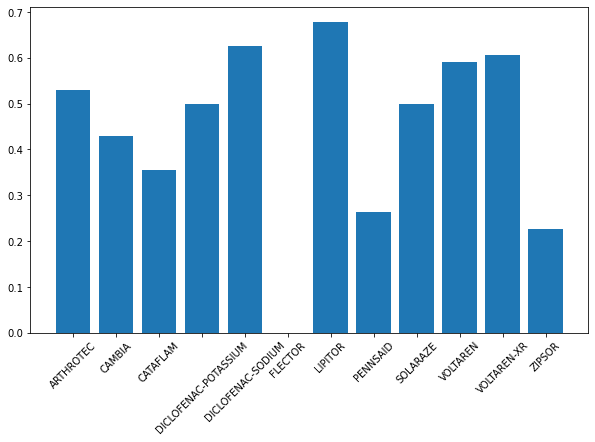

In [17]:
# frequency of ADR tags for each drug
def freq_ADR(tags):
    return sum([tag.startswith('ADR') for tag in tags]) / len(tags)

plt.figure(figsize=(10,6))
plt.bar(Drugs, [freq_ADR(Tags[drug]) for drug in Drugs])
plt.xticks(rotation=45)
plt.show()